In [ ]:
# References:
# https://github.com/milesial/Pytorch-UNet/tree/67bf11b4db4c5f2891bd7e8e7f58bcde8ee2d2db

In [ ]:
# !pip install torch torchvision

### UNET Generation (One Image)

In [1]:
import torch
from torchvision import transforms, datasets
from torch import nn, optim
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

In [2]:
# PARAMETERS
img_size = 256
noise = torch.randn(1, 3, img_size, img_size)
image_url = "https://raw.githubusercontent.com/yungewww/AIGC-LLM-ToolBox/refs/heads/main/dataset/cat.jpg"

torch.Size([1, 3, 256, 256])


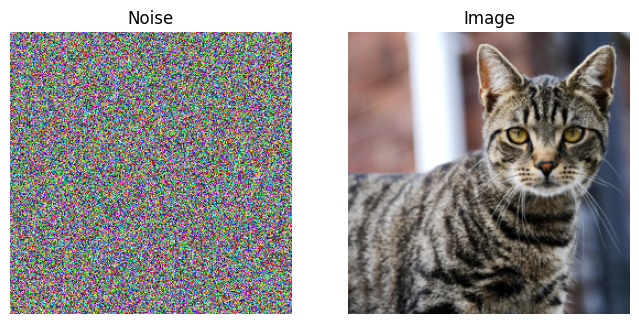

In [3]:
# PREPROCESS IMAGE

def preprocess_image(url, img_size, type = 'image'):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])
    tensor = transform(img).unsqueeze(0)

    return tensor

def show_tensor_images(tensors, names=None):
    num_imgs = len(tensors)
    fig, axs = plt.subplots(1, num_imgs, figsize=(num_imgs * 4, 4))

    if num_imgs == 1:
        axs = [axs]

    for i, tensor in enumerate(tensors):
        img = transforms.ToPILImage()(tensor.squeeze(0))
        axs[i].imshow(img)
        if names is not None and len(names) > i:
            axs[i].set_title(names[i])
        else:
            axs[i].set_title(f'Image {i+1}')
        axs[i].axis('off')  # 关闭坐标轴

    plt.show()

# tensor shape should be (1, C, H, W)
image_tensor = preprocess_image(image_url, img_size)
print(image_tensor.shape)

show_tensor_images([noise, image_tensor], ['Noise', 'Image'])

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class UNetForImageGeneration(nn.Module):
    def __init__(self, out_channels=3):
        super(UNetForImageGeneration, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        # Contracting path
        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = CBR(512, 1024)

        # Expanding path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)

        # 生成 RGB 图像，因此输出 3 个通道
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoding
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        # 使用 tanh 来将输出的像素值限制在 [-1, 1] 之间
        return torch.tanh(self.final(dec1))

# 实例化模型，生成 RGB 图像
model = UNetForImageGeneration(out_channels=3).to('cuda')

torch.Size([1, 3, 256, 256])


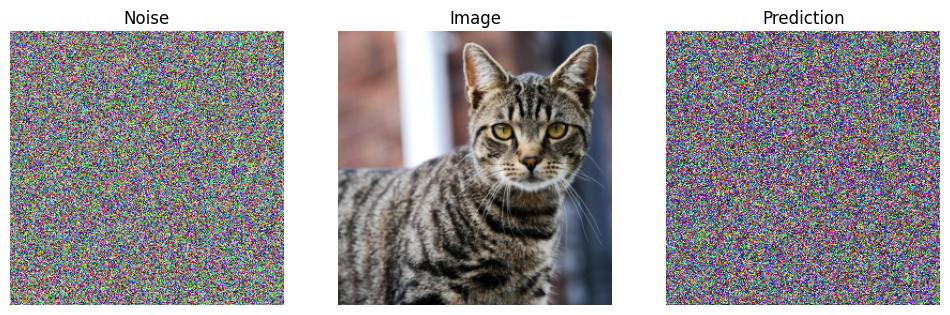

In [5]:
# IF NOT TRAINED
pred = model(noise.to('cuda'))
print(pred.shape)
show_tensor_images([noise, image_tensor, pred], ['Noise', 'Image', 'Prediction'])

Epoch [1/200], Loss: 0.002043992979452014
Epoch [2/200], Loss: 0.05915307253599167
Epoch [3/200], Loss: 0.019509917125105858
Epoch [4/200], Loss: 0.024101516231894493
Epoch [5/200], Loss: 0.01528911478817463
Epoch [6/200], Loss: 0.011929775588214397
Epoch [7/200], Loss: 0.009734740480780602
Epoch [8/200], Loss: 0.007941624149680138
Epoch [9/200], Loss: 0.007816819474101067
Epoch [10/200], Loss: 0.007174387574195862
Epoch [11/200], Loss: 0.006073247641324997
Epoch [12/200], Loss: 0.005637270864099264
Epoch [13/200], Loss: 0.005438370630145073
Epoch [14/200], Loss: 0.00507606565952301
Epoch [15/200], Loss: 0.004568564239889383
Epoch [16/200], Loss: 0.004325804300606251
Epoch [17/200], Loss: 0.004120471887290478
Epoch [18/200], Loss: 0.0038264780305325985
Epoch [19/200], Loss: 0.0035001500509679317
Epoch [20/200], Loss: 0.0032614560332149267
Epoch [21/200], Loss: 0.003086049808189273
Epoch [22/200], Loss: 0.0029559223912656307
Epoch [23/200], Loss: 0.0027832365594804287
Epoch [24/200], Lo

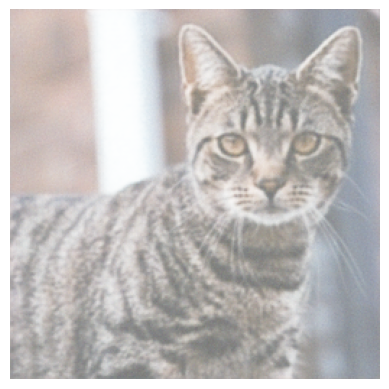

Epoch [51/200], Loss: 0.0009001350263133645
Epoch [52/200], Loss: 0.0008763548685237765
Epoch [53/200], Loss: 0.000853906269185245
Epoch [54/200], Loss: 0.00083107192767784
Epoch [55/200], Loss: 0.0008107735775411129
Epoch [56/200], Loss: 0.000791122845839709
Epoch [57/200], Loss: 0.0007722405716776848
Epoch [58/200], Loss: 0.0007543571991845965
Epoch [59/200], Loss: 0.0007351019885390997
Epoch [60/200], Loss: 0.0007179946405813098
Epoch [61/200], Loss: 0.0007028168765828013
Epoch [62/200], Loss: 0.0006866790354251862
Epoch [63/200], Loss: 0.0006707410211674869
Epoch [64/200], Loss: 0.0006559179164469242
Epoch [65/200], Loss: 0.0006419534329324961
Epoch [66/200], Loss: 0.0006280149100348353
Epoch [67/200], Loss: 0.0006142044439911842
Epoch [68/200], Loss: 0.0006014081882312894
Epoch [69/200], Loss: 0.000589075731113553
Epoch [70/200], Loss: 0.0005768253467977047
Epoch [71/200], Loss: 0.0005645353230647743
Epoch [72/200], Loss: 0.0005529397167265415
Epoch [73/200], Loss: 0.0005419636145

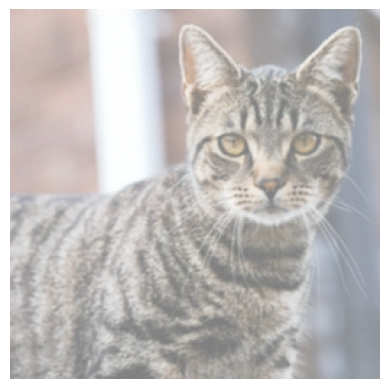

Epoch [101/200], Loss: 0.000385480176191777
Epoch [102/200], Loss: 0.0004387508088257164
Epoch [103/200], Loss: 0.00042155245319008827
Epoch [104/200], Loss: 0.00033442172571085393
Epoch [105/200], Loss: 0.00031570723513141274
Epoch [106/200], Loss: 0.00036003364948555827
Epoch [107/200], Loss: 0.00030861503910273314
Epoch [108/200], Loss: 0.000303729553706944
Epoch [109/200], Loss: 0.00032054807525128126
Epoch [110/200], Loss: 0.00027957078418694437
Epoch [111/200], Loss: 0.00029879872454330325
Epoch [112/200], Loss: 0.00028139096684753895
Epoch [113/200], Loss: 0.00027087709167972207
Epoch [114/200], Loss: 0.0002794286410789937
Epoch [115/200], Loss: 0.00025563250528648496
Epoch [116/200], Loss: 0.0002671139081940055
Epoch [117/200], Loss: 0.0002503568830434233
Epoch [118/200], Loss: 0.00025016869767569005
Epoch [119/200], Loss: 0.0002469842729624361
Epoch [120/200], Loss: 0.00023596498067490757
Epoch [121/200], Loss: 0.00024035782553255558
Epoch [122/200], Loss: 0.000226970863877795

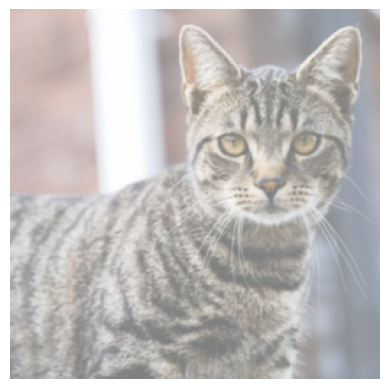

Epoch [151/200], Loss: 0.00014366446703206748
Epoch [152/200], Loss: 0.00014108940376900136
Epoch [153/200], Loss: 0.00013931916328147054
Epoch [154/200], Loss: 0.00013723046868108213
Epoch [155/200], Loss: 0.00013500344357453287
Epoch [156/200], Loss: 0.0001333195250481367
Epoch [157/200], Loss: 0.00013127601414453238
Epoch [158/200], Loss: 0.00012924183101858944
Epoch [159/200], Loss: 0.00012759017408825457
Epoch [160/200], Loss: 0.00012564263306558132
Epoch [161/200], Loss: 0.00012381415581330657
Epoch [162/200], Loss: 0.00012223879457451403
Epoch [163/200], Loss: 0.0001203875508508645
Epoch [164/200], Loss: 0.00011866312706843019
Epoch [165/200], Loss: 0.00011715090658981353
Epoch [166/200], Loss: 0.0001154294004663825
Epoch [167/200], Loss: 0.00011380085197743028
Epoch [168/200], Loss: 0.00011234583507757634
Epoch [169/200], Loss: 0.00011074638314312324
Epoch [170/200], Loss: 0.00010917510371655226
Epoch [171/200], Loss: 0.00010779353033285588
Epoch [172/200], Loss: 0.000106333696

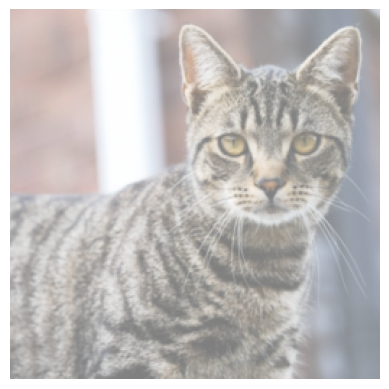

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

noise = noise.to('cuda')
image_tensor = image_tensor.to('cuda')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model_single_image(model, image, label, criterion, optimizer, num_epochs=10, save_interval=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0

        # Forward
        outputs = model(image)
        loss = criterion(outputs, label)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss}")

        # 定期保存和显示生成的图像（例如每5个epoch）
        if (epoch + 1) % save_interval == 0:
            save_generated_image(outputs, epoch + 1)

def save_generated_image(tensor, epoch):
    # 将生成的张量从 [-1, 1] 转换为 [0, 1] 以便显示
    img = tensor.detach().cpu().squeeze(0)  # 移除批次维度
    img = (img + 1) / 2  # 假设输出经过 tanh, 需要将其从 [-1, 1] 还原到 [0, 1]

    # 保存生成的图片
    plt.imshow(img.permute(1, 2, 0))  # 将形状从 [C, H, W] 转换为 [H, W, C] 以便显示
    plt.axis('off')
    plt.savefig(f"generated_image_epoch_{epoch}.png")
    plt.show()

# 开始训练，假设噪声为输入，image_tensor 为目标
train_model_single_image(model, noise, image_tensor, criterion, optimizer, num_epochs=200, save_interval=50)


torch.Size([1, 3, 256, 256])


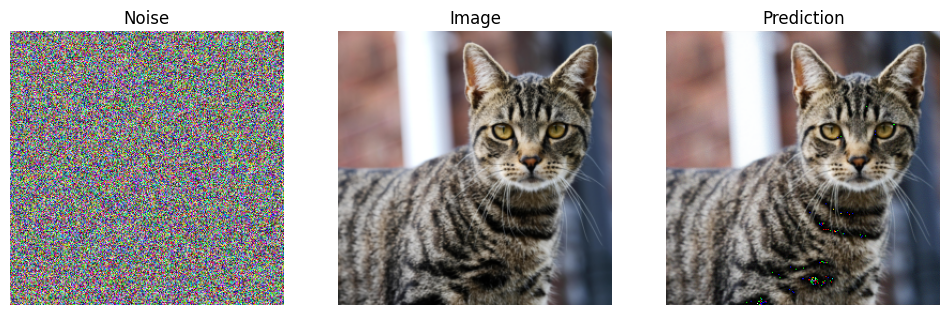

In [11]:
# PREDICTION
pred = model(noise.to('cuda'))
print(pred.shape)
show_tensor_images([noise, image_tensor, pred], ['Noise', 'Image', 'Prediction'])

torch.Size([1, 3, 256, 256])


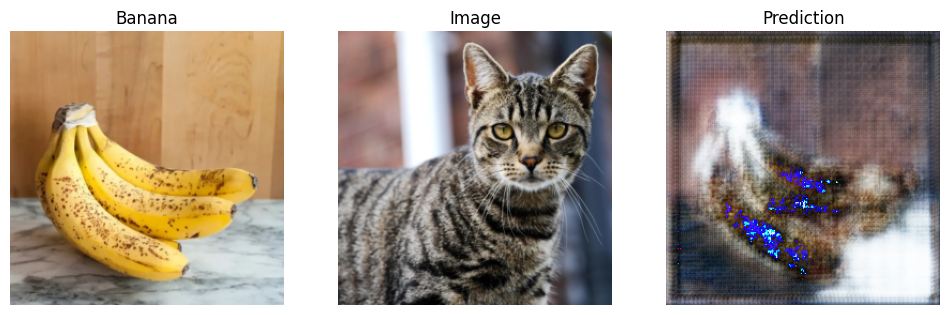

In [12]:
# IF INPUT IMAGE IS IRRELEVANT
banana_url = 'https://raw.githubusercontent.com/yungewww/GenAI-LLM-ToolBox/refs/heads/main/dataset/banana.jpg'
banana = preprocess_image(banana_url, img_size)

pred = model(banana.to('cuda'))
print(pred.shape)
show_tensor_images([banana, image_tensor, pred], ['Banana', 'Image', 'Prediction'])